In [1]:
# Extracción: Conexión a Drive y DuckDB.

from google.colab import drive

# Montar Drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/Colab Notebooks/Predicción de crédito/'

application = base_path + 'application_train.csv'
bureau = base_path + 'bureau.csv'
payments = base_path + 'installments_payments.csv'
previous = base_path + 'previous_application.csv'

Mounted at /content/drive


In [2]:
# Transformación (SQL): Limpieza y agregación de las 4 fuentes (Vistas).

import duckdb
import pandas as pd
import numpy as np

# Conexión en memoria
con = duckdb.connect(database=':memory:')

# 1. BUREAU: Deuda Externa (Agregamos el conteo de préstamos activos)
query_bureau = f"""
CREATE OR REPLACE VIEW bureau_agg AS
SELECT
    SK_ID_CURR,
    COUNT(*) as bureau_loan_count,
    SUM(AMT_CREDIT_SUM_DEBT) as total_external_debt,
    MAX(AMT_CREDIT_SUM_OVERDUE) as max_external_overdue,
    SUM(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) as active_loan_count
FROM read_csv_auto('{bureau}')
GROUP BY SK_ID_CURR
"""

# 2. INSTALLMENTS: Voluntad de Pago (Mantenemos el ratio y días de mora)
query_install = f"""
CREATE OR REPLACE VIEW install_agg AS
SELECT
    SK_ID_CURR,
    AVG(AMT_PAYMENT / NULLIF(AMT_INSTALMENT, 0)) as avg_payment_ratio,
    AVG(DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT) as avg_days_late,
    COUNT(*) as total_installments_done
FROM read_csv_auto('{payments}')
GROUP BY SK_ID_CURR
"""

# 3. PREVIOUS APP: Memoria Interna (La pieza que faltaba)
# El ratio de rechazo es un predictor BRUTAL de default
query_prev = f"""
CREATE OR REPLACE VIEW prev_agg AS
SELECT
    SK_ID_CURR,
    COUNT(*) as total_prev_apps,
    AVG(CASE WHEN NAME_CONTRACT_STATUS = 'Refused' THEN 1 ELSE 0 END) as internal_rejection_rate,
    SUM(AMT_ANNUITY) as total_prev_annuity
FROM read_csv_auto('{previous}')
GROUP BY SK_ID_CURR
"""

# 4. TABLA MAESTRA: Unión de las 4 fuentes
query_master = f"""
SELECT
    app.SK_ID_CURR,
    app.TARGET,
    app.NAME_CONTRACT_TYPE,
    app.AMT_INCOME_TOTAL,
    app.AMT_CREDIT,
    app.AMT_ANNUITY,
    app.DAYS_BIRTH / -365.0 as age_years,
    app.DAYS_EMPLOYED as days_employed_raw,
    app.EXT_SOURCE_2,
    app.EXT_SOURCE_3,

    -- Bureau
    COALESCE(b.total_external_debt, 0) as total_external_debt,
    COALESCE(b.max_external_overdue, 0) as max_external_overdue, -- Added this line
    COALESCE(b.active_loan_count, 0) as active_loan_count,

    -- Pagos
    COALESCE(i.avg_payment_ratio, 1.0) as avg_payment_ratio,
    COALESCE(i.avg_days_late, 0) as avg_days_late,

    -- Historial Interno
    COALESCE(p.internal_rejection_rate, 0) as internal_rejection_rate,
    COALESCE(p.total_prev_apps, 0) as total_prev_apps

FROM read_csv_auto('{application}') app
LEFT JOIN bureau_agg b ON app.SK_ID_CURR = b.SK_ID_CURR
LEFT JOIN install_agg i ON app.SK_ID_CURR = i.SK_ID_CURR
LEFT JOIN prev_agg p    ON app.SK_ID_CURR = p.SK_ID_CURR
"""

# --- AUDITORÍA (DQC) Y CALIDAD DE DATOS (Estilo Bancario) ---

def run_audit(con, tables):
    print(f"{' REPORTE DE AUDITORÍA DE DATOS ':=^40}")
    for table in tables:
        # Contamos nulos y volumen total por tabla
        audit_query = f"""
        SELECT
            '{table}' as tabla,
            COUNT(*) as total_registros,
            SUM(CASE WHEN SK_ID_CURR IS NULL THEN 1 ELSE 0 END) as nulos_id,
            APPROX_COUNT_DISTINCT(SK_ID_CURR) as clientes_unicos
        FROM {table}
        """
        res = con.execute(audit_query).df()
        print(f"📊 Tabla: {res['tabla'][0]} | Registros: {res['total_registros'][0]} | Clientes Únicos: {res['clientes_unicos'][0]}")
    print("="*40)
    print(f"{' FIN DEL REPORTE ':=^40}")


# Ejecutar el Pipeline
con.execute(query_bureau)
con.execute(query_install)
con.execute(query_prev)
df_master = con.execute(query_master).df()

# --- AJUSTE DE LIMPIEZA ---
# Primero: Limpiamos el error de sistema (365243 -> NaN)
df_master['days_employed_raw'].replace(365243, np.nan, inplace=True)

# Segundo: Creamos la variable final en años positivos
# El .abs() es vital para que la restricción monotónica -1 funcione
df_master['years_employed'] = df_master['days_employed_raw'].abs() / 365.0

# Tercero: Rellenamos nulos con 0 (asumiendo que si no hay dato, no tiene antigüedad)
df_master['years_employed'].fillna(0, inplace=True)

print(f"✅ ¡Éxito! Dataset consolidado con ({df_master.shape[0]},{df_master.shape[1]})")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ ¡Éxito! Dataset consolidado con (307511,18)


/tmp/ipython-input-164415181.py:109: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['days_employed_raw'].replace(365243, np.nan, inplace=True)
/tmp/ipython-input-164415181.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [3]:
from scipy.stats import skew
from scipy.stats.mstats import winsorize
import numpy as np

# 1. Limpieza de valores erróneos conocidos
# 365243 es un error común en este dataset para personas desempleadas o jubiladas
# df_master['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # This column was removed in the previous step

# 2. Aplicar Winsorize para "capar" outliers en el percentil 99
# Esto evita que un multimillonario distorsione la escala del modelo
cols_to_winsorize = ['AMT_INCOME_TOTAL', 'total_external_debt', 'AMT_CREDIT', 'AMT_ANNUITY']

for col in cols_to_winsorize:
    if col in df_master.columns:
        # Ponemos el techo en el 99%, sin tocar el suelo (0%)
        df_master[col] = winsorize(df_master[col], limits=[0, 0.01])

# 3. Identificar Asimetría Alta y aplicar Logaritmo
# En finanzas, los montos suelen tener mucha asimetría a la derecha
numeric_cols = df_master.select_dtypes(include=[np.number]).columns
threshold = 1.0  # Umbral de asimetría

for col in numeric_cols:
    # Ignoramos el TARGET y variables de ID
    if col in ['TARGET', 'SK_ID_CURR']: continue

    current_skew = df_master[col].skew()

    if abs(current_skew) > threshold:
        # Verificamos que los valores sean positivos para el logaritmo
        # Sumamos 1 (log1p) para manejar ceros de forma segura
        if df_master[col].min() >= 0:
            print(f"🚀 Transformando {col} | Skew original: {current_skew:.2f}")
            df_master[col] = np.log1p(df_master[col])
        else:
            print(f"⚠️ {col} tiene asimetría ({current_skew:.2f}) pero contiene negativos. Se queda igual.")

print("\n✅ Tratamiento de asimetría completado.")

🚀 Transformando AMT_INCOME_TOTAL | Skew original: 1.35
🚀 Transformando AMT_CREDIT | Skew original: 1.02
⚠️ days_employed_raw tiene asimetría (-1.97) pero contiene negativos. Se queda igual.
⚠️ total_external_debt tiene asimetría (3.61) pero contiene negativos. Se queda igual.
🚀 Transformando max_external_overdue | Skew original: 192.75
🚀 Transformando active_loan_count | Skew original: 1.45
🚀 Transformando avg_payment_ratio | Skew original: 164.20
⚠️ avg_days_late tiene asimetría (25.06) pero contiene negativos. Se queda igual.
🚀 Transformando internal_rejection_rate | Skew original: 1.81
🚀 Transformando total_prev_apps | Skew original: 2.24
🚀 Transformando years_employed | Skew original: 2.05

✅ Tratamiento de asimetría completado.


In [4]:
# Enriquecimiento: Inyección de los Ratios de Negocio (Leverage, Friction).

# 1. Global Leverage (Evitamos división por 0)
df_master['RATIO_GLOBAL_LEVERAGE'] = (df_master['total_external_debt'] + df_master['AMT_CREDIT']) / (df_master['AMT_INCOME_TOTAL'] + 1)

# 2. Payment Friction (Días tarde ponderados por deuda vencida externa)
# Si tiene mora externa, penaliza x1000, más los días de retraso interno
df_master['SCORE_PAYMENT_FRICTION'] = df_master['avg_days_late'] + (np.where(df_master['max_external_overdue'] > 0, 100, 0))

# 3. Annuity Burden (Carga Financiera Mensual)
df_master['RATIO_ANNUITY_INCOME'] = df_master['AMT_ANNUITY'] / (df_master['AMT_INCOME_TOTAL'] / 12 + 1)

# Limpieza de seguridad para los nuevos ratios
cols_ratios = ['RATIO_GLOBAL_LEVERAGE', 'SCORE_PAYMENT_FRICTION', 'RATIO_ANNUITY_INCOME']

# Reemplazar infinitos por el valor máximo y nulos por la mediana (o 0)
for col in cols_ratios:
    df_master[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_master[col].fillna(df_master[col].median(), inplace=True)

print("✅ Ratios de negocio integrados y saneados.")

✅ Ratios de negocio integrados y saneados.


/tmp/ipython-input-1736748891.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-1736748891.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [5]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. SELECCIÓN DE FEATURES ESTRATÉGICAS ---
# Incluimos years_employed (estabilidad) y age_years (madurez)
features = [
    'AMT_INCOME_TOTAL',
    'age_years',              # Edad del cliente (Años +)
    'years_employed',         # Antigüedad laboral (Años +)
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'total_external_debt',
    'avg_payment_ratio',
    'internal_rejection_rate',
    'RATIO_GLOBAL_LEVERAGE',
    'SCORE_PAYMENT_FRICTION',
    'RATIO_ANNUITY_INCOME'
]

X = df_master[features]
y = df_master['TARGET']

# --- 2. SPLIT DE DATOS ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. CONFIGURACIÓN DE RESTRICCIONES MONOTÓNICAS ---
# -1: Si la variable sube, el riesgo BAJA.
#  1: Si la variable sube, el riesgo SUBE.
constraints = {
    'AMT_INCOME_TOTAL': -1,
    'age_years': -1,              # A más edad, estadísticamente menos riesgo
    'years_employed': -1,         # A más antigüedad, menos riesgo
    'EXT_SOURCE_2': -1,
    'EXT_SOURCE_3': -1,
    'total_external_debt': 1,
    'avg_payment_ratio': -1,      # A mejor cumplimiento, menos riesgo
    'internal_rejection_rate': 1, # Más rechazos previos, más riesgo
    'RATIO_GLOBAL_LEVERAGE': 1,   # Más apalancamiento, más riesgo
    'SCORE_PAYMENT_FRICTION': 1,  # Más fricción de pago, más riesgo
    'RATIO_ANNUITY_INCOME': 1     # Mayor carga financiera, más riesgo
}

# Creamos la tupla respetando el orden exacto de las columnas en X_train
constraint_tuple = tuple([constraints.get(col, 0) for col in X_train.columns])

# --- 4. ENTRENAMIENTO DEL MODELO XGBOOST ---
model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=11,          # Compensación por desbalanceo (clase 1 es escasa)
    monotone_constraints=constraint_tuple,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50      # Detiene el entrenamiento si el error de validación no baja
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=50
)

print("\n✅ Modelo entrenado con éxito.")

[0]	validation_0-logloss:0.67530	validation_1-logloss:0.67528
[50]	validation_0-logloss:0.60852	validation_1-logloss:0.60858
[100]	validation_0-logloss:0.59629	validation_1-logloss:0.59669
[150]	validation_0-logloss:0.59242	validation_1-logloss:0.59309
[200]	validation_0-logloss:0.58964	validation_1-logloss:0.59052
[250]	validation_0-logloss:0.58778	validation_1-logloss:0.58883
[300]	validation_0-logloss:0.58686	validation_1-logloss:0.58809
[350]	validation_0-logloss:0.58632	validation_1-logloss:0.58769
[400]	validation_0-logloss:0.58606	validation_1-logloss:0.58755
[450]	validation_0-logloss:0.58567	validation_1-logloss:0.58728
[495]	validation_0-logloss:0.58569	validation_1-logloss:0.58739

✅ Modelo entrenado con éxito.


/tmp/ipython-input-594269359.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


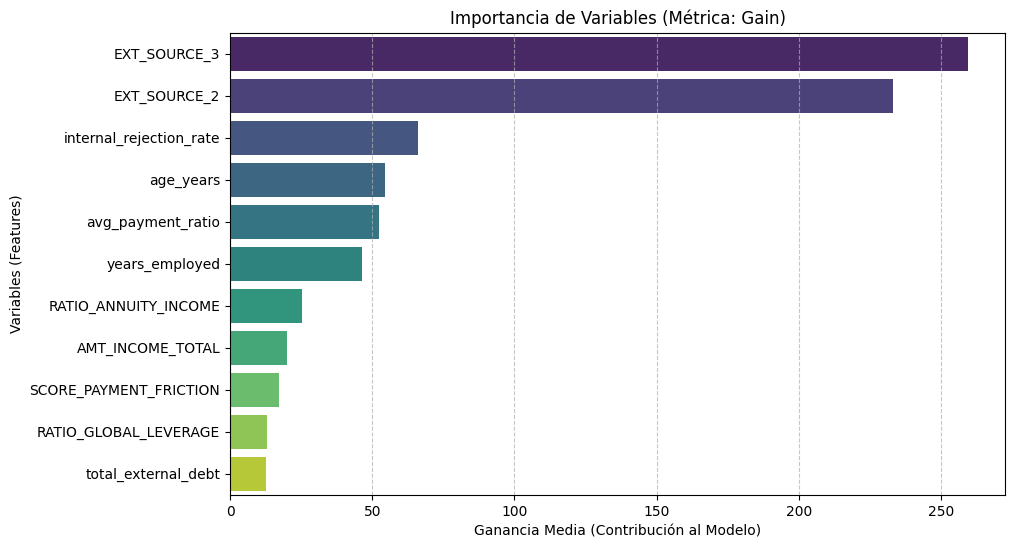


✅ La variable más influyente es: EXT_SOURCE_3


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer la importancia de las variables (usando 'gain' que es el más preciso)
importance_type = 'gain'
importance_scores = model.get_booster().get_score(importance_type=importance_type)

# 2. Convertir a DataFrame para graficar
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance': list(importance_scores.values())
}).sort_values(by='Importance', ascending=False)

# 3. Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title(f'Importancia de Variables (Métrica: {importance_type.capitalize()})')
plt.xlabel('Ganancia Media (Contribución al Modelo)')
plt.ylabel('Variables (Features)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 4. Breve Análisis
top_feature = importance_df.iloc[0]['Feature']
print(f"\n✅ La variable más influyente es: {top_feature}")

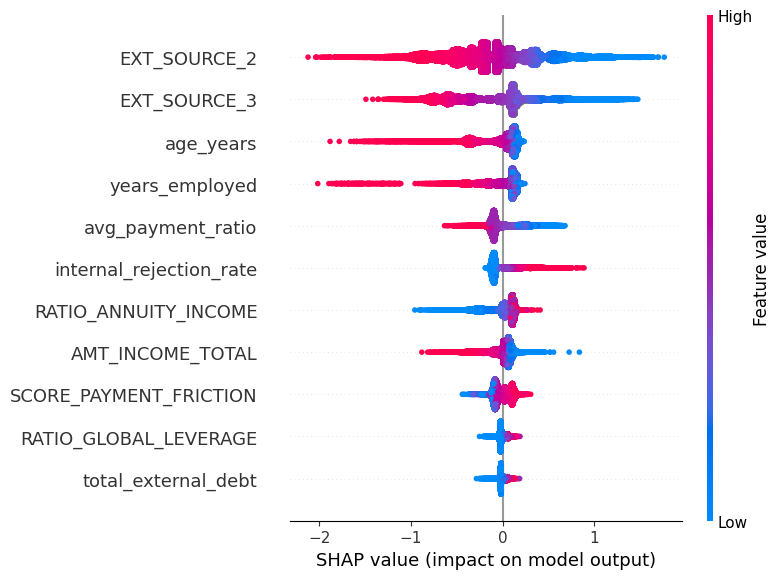

In [8]:
import shap

# 1. Crear el explicador (usando el modelo XGBoost ganador)
# Using model_xgb from the benchmarking cell (GGzI98INXKgq) as 'model' is no longer defined.
explainer = shap.TreeExplainer(model)

# 2. Calcular los valores SHAP para el conjunto de test
# Note: X_test here is the one from the most recent train_test_split (test_size=0.25) in GGzI98INXKgq
shap_values = explainer.shap_values(X_test)

# 3. Visualización del Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
#plt.title("Impacto SHAP: 4 Datasets + Ingeniería de Ratios", fontsize=15)
plt.show()

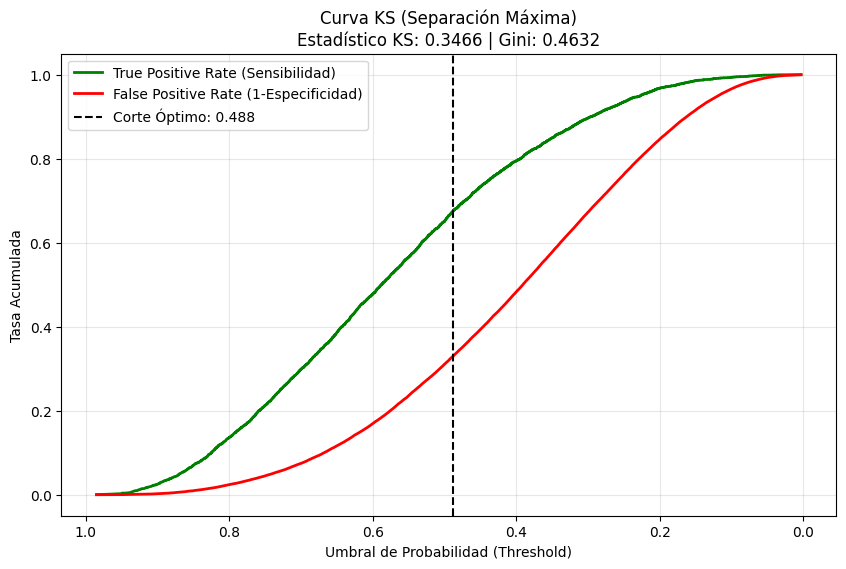

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Obtención de Probabilidades
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Métricas de Performance Core
auc = roc_auc_score(y_test, y_probs)
gini = 2 * auc - 1  # Relación directa Gini-AUC

# 3. Cálculo de Curva KS, FPR y TPR
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
ks_values = tpr - fpr
max_ks_index = np.argmax(ks_values)
optimal_cutoff = thresholds[max_ks_index]
ks_stat = ks_values[max_ks_index]

# --- VISUALIZACIÓN 1: CURVA KS ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='True Positive Rate (Sensibilidad)', color='green', lw=2)
plt.plot(thresholds, fpr, label='False Positive Rate (1-Especificidad)', color='red', lw=2)
plt.axvline(optimal_cutoff, color='black', linestyle='--', label=f'Corte Óptimo: {optimal_cutoff:.3f}')
plt.title(f'Curva KS (Separación Máxima)\nEstadístico KS: {ks_stat:.4f} | Gini: {gini:.4f}')
plt.xlabel('Umbral de Probabilidad (Threshold)')
plt.ylabel('Tasa Acumulada')
plt.legend()
plt.grid(alpha=0.3)
plt.gca().invert_xaxis() # El threshold suele ir de 1 a 0
plt.show()

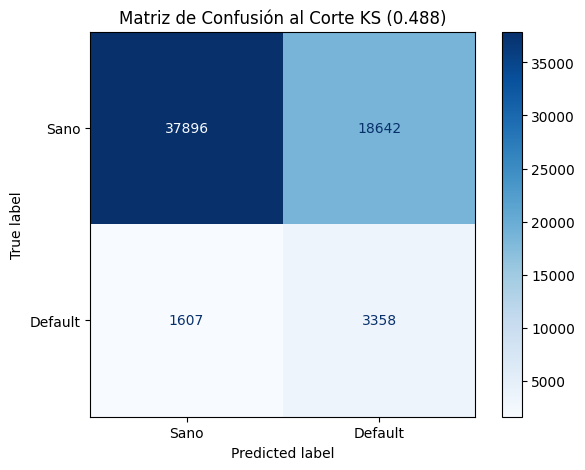

=========== METRICAS FINALES ===========
AUC Score: 0.7316
Coeficiente Gini: 0.4632
Estadístico KS: 0.3466
Threshold Seleccionado: 0.4880
True Positive Rate (Atrapamos al % de morosos): 67.63%
False Positive Rate (Rechazamos al % de buenos): 32.97%

==== REPORTE DE IMPACTO DE NEGOCIO =====
✅ Clientes Buenos que generarán intereses: 37896
🛡️ Intentos de Default prevenidos con éxito: 3358
⚠️ Costo de Oportunidad (Buenos rechazados): 18642
❌ Pérdida Directa (Morosos que se filtraron): 1607


In [ ]:
# --- VISUALIZACIÓN 2: MATRIZ DE CONFUSIÓN ---
y_pred_optimized = (y_probs >= optimal_cutoff).astype(int)
cm = confusion_matrix(y_test, y_pred_optimized)

fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sano', 'Default'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Matriz de Confusión al Corte KS ({optimal_cutoff:.3f})')
plt.show()

# --- REPORTE DE IMPACTO Y MÉTRICAS FINALES ---
tn, fp, fn, tp = cm.ravel()
tpr_final = tp / (tp + fn)
fpr_final = fp / (fp + tn)

print(f"{' METRICAS FINALES ':=^40}")
print(f"AUC Score: {auc:.4f}")
print(f"Coeficiente Gini: {gini:.4f}")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"Threshold Seleccionado: {optimal_cutoff:.4f}")
print(f"True Positive Rate (Atrapamos al % de morosos): {tpr_final:.2%}")
print(f"False Positive Rate (Rechazamos al % de buenos): {fpr_final:.2%}")

print(f"\n{' REPORTE DE IMPACTO DE NEGOCIO ':=^40}")
print(f"✅ Clientes Buenos que generarán intereses: {tn}")
print(f"🛡️ Intentos de Default prevenidos con éxito: {tp}")
print(f"⚠️ Costo de Oportunidad (Buenos rechazados): {fp}")
print(f"❌ Pérdida Directa (Morosos que se filtraron): {fn}")

========= INICIANDO BENCHMARK ==========
🚀 Entrenando Logit Regression...
   >>> AUC: 0.7204 | Gini: 0.4409
🚀 Entrenando Random Forest...
   >>> AUC: 0.7286 | Gini: 0.4571
🚀 Entrenando XGBoost...
   >>> AUC: 0.7325 | Gini: 0.4649


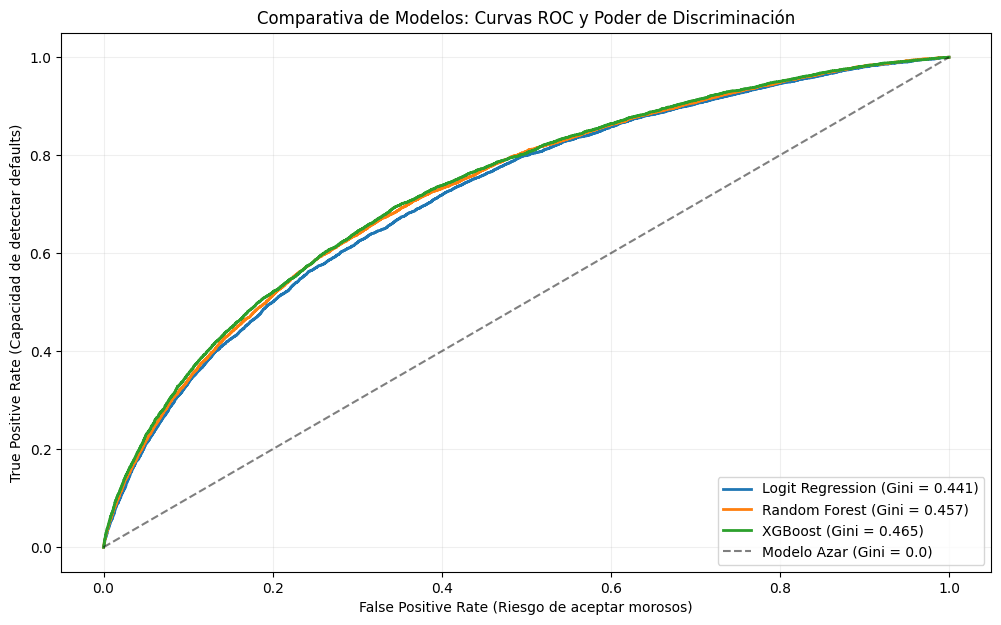


RANKING FINAL DE MODELOS:
                       auc      gini
XGBoost           0.732468  0.464936
Random Forest     0.728554  0.457107
Logit Regression  0.720444  0.440888


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Preparación de datos (Usando tu df_master real)
# Asegúrate de haber ejecutado las celdas de limpieza y ratios antes
X = df_master[features]
y = df_master['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- DEFINICIÓN DE MODELOS (Estrategias Diferentes) ---

# A. Regresión Logística: El modelo lineal tradicional (Auditable pero rígido)
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', C=0.1))
])

# B. Random Forest: El ensamble robusto (Maneja no-linealidad)
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', n_jobs=-1, random_state=42))
])

# C. XGBoost: El retador de alta precisión (Maneja nulos y lógica monotónica)
ratio_neg_pos = (y_train == 0).sum() / (y_train == 1).sum()
model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=ratio_neg_pos,
    monotone_constraints=constraint_tuple, # Aplicamos la lógica de negocio que definimos
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# --- ENTRENAMIENTO Y COMPETENCIA ---

results = {}

print(f"{' INICIANDO BENCHMARK ':=^40}")
for name, model in [('Logit Regression', pipe_lr), ('Random Forest', pipe_rf), ('XGBoost', model_xgb)]:
    print(f"🚀 Entrenando {name}...")
    model.fit(X_train, y_train)

    # Probabilidades
    preds = model.predict_proba(X_test)[:, 1]

    # Métricas: AUC y Gini
    auc = roc_auc_score(y_test, preds)
    gini = 2 * auc - 1
    results[name] = {'auc': auc, 'gini': gini, 'preds': preds}
    print(f"   >>> AUC: {auc:.4f} | Gini: {gini:.4f}")

# --- VISUALIZACIÓN DE RESULTADOS ---

plt.figure(figsize=(12, 7))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['preds'])
    plt.plot(fpr, tpr, label=f"{name} (Gini = {res['gini']:.3f})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Modelo Azar (Gini = 0.0)')
plt.xlabel('False Positive Rate (Riesgo de aceptar morosos)')
plt.ylabel('True Positive Rate (Capacidad de detectar defaults)')
plt.title('Comparativa de Modelos: Curvas ROC y Poder de Discriminación')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

# Resumen en Tabla
summary = pd.DataFrame(results).T[['auc', 'gini']].sort_values(by='gini', ascending=False)
print("\nRANKING FINAL DE MODELOS:")
print(summary)